In [8]:
from mainv3 import SystemDesign

- use weighting as a variable
- encorporate for javh_groups

### Plan of system creation ofr ja_groups
```python
system_columns = ['solvent_1','solvent_2','temperature','compound_id']
extra_fitted_points=1-4

```

In [25]:
system_5 = {
    'system_columns': ['solvent_1', 'solvent_2', 'temperature'],
    'extra_fitted_points': 1,
    'name': 'system_sst_1',
}

system_6 = {
    'system_columns': ['solvent_1', 'solvent_2', 'temperature'],
    'extra_fitted_points': 2,
    'name': 'system_sst_2',
}

system_7 = {
    'system_columns': ['solvent_1', 'solvent_2'],
    'extra_fitted_points': 1,
    'name': 'system_ss_1',
}

system_8 = {
    'system_columns': ['solvent_1', 'solvent_2'],
    'extra_fitted_points': 2,
    'name': 'system_ss_2',
}

system_9 = {
    'system_columns': ['solvent_1'],
    'extra_fitted_points': 1,
    'name': 'system_s_1',
}

system_10 = {
    'system_columns': ['solvent_1'],
    'extra_fitted_points': 2,
    'name': 'system_s_2',
}

system_11 = {
    'system_columns': [],
    'extra_fitted_points': 1,
    'name': 'system_1',
}

system_12 = {
    'system_columns': [],
    'extra_fitted_points': 2,
    'name': 'system_1',
}

system_13 = {
    'system_columns': [],
    'extra_fitted_points': 3,
    'name': 'system_3',
}

system_14 = {
    'system_columns': [],
    'extra_fitted_points': 3,
    'name': 'system_3',
}

systems = [
    system_5,
    system_6,
    system_7,
    system_8,
    system_9,
    system_10,
    system_11,
    system_12,
    system_13,
    system_14
]

from vae_model import VAEWithFeatureSelection
from neural_network_model import NeuralNetworkWithFeatureSelection
from xgb_model import XGBoostWithFeatureSelection
from itertools import product


models = [
    {
        'name': 'vae',
        'model_class' : VAEWithFeatureSelection
    },
    {
        'name': 'nn',
        'model_class' : NeuralNetworkWithFeatureSelection
    },
    {
        'name': 'xgb',
        'model_class' : XGBoostWithFeatureSelection
    }
]

n_features = [
    {
        'name': '10_features',
        'n_features': 10
    },
    {
        'name': '50_features',
        'n_features': 50
    },
    {
        'name': '500_features',
        'n_features': 500
    }
]

systemPermutations = [
    {
        'system': system,
        'model': model,
        'n_features': n_feature
    }
    for system, model, n_feature in product(systems, models, n_features)
]

len(systemPermutations)

90

In [ ]:
import time
import os

def train_and_save_system(system_permutation, raw_data_path='curve_fit_results_x_is_7.csv', base_save_path="../../output/models/"):
    """
    Train and save a model system based on a system permutation configuration.
    
    Args:
        system_permutation (dict): Dictionary containing system, model, and n_features configurations
        raw_data_path (str): Path to the raw data file
        base_save_path (str): Base directory for saving models
    """
    # Extract configuration
    system_config = system_permutation['system']
    model_config = system_permutation['model']
    n_features_config = system_permutation['n_features']
    
    print(f"Training {model_config['name']} model with {system_config['name']} using {n_features_config['name']}")
    
    # Create system
    system = SystemDesign(
        system_columns=system_config['system_columns'],
        raw_data_path=raw_data_path,
        extra_fitted_points=system_config['extra_fitted_points'],
        target_columns=['J0', 'J1', 'J2']
    )
    
    # Common parameters for all models
    common_params = {
        'feature_selection_method': 'random_forest',
        'n_features': n_features_config['n_features'],
        'keep_prefixes': ['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
        'verbose': 1,
        'optimize_hyperparams': True,
        'n_calls': 150
    }
    
    # Model-specific parameters
    if model_config['name'] == 'vae':
        model_params = {
            'epochs': 1000,
            'batch_size': 32,
            'latent_dim': 16,
            'kl_weight': 0.001
        }
    elif model_config['name'] == 'nn':
        model_params = {
            'epochs': 1000,
            'batch_size': 32
        }
    elif model_config['name'] == 'xgb':
        model_params = {
            'n_estimators': 200,
            'max_depth': 6
        }
    
    # Train the model
    system.train_model(
        model_class=model_config['model_class'],
        **common_params,
        **model_params
    )
    
    # Evaluate the model
    system.evaluate_model()
    
    # Construct save path
    model_name = f"{model_config['name']}_{system_config['name']}_{n_features_config['name']}.pkl"
    save_path = base_save_path + model_name
    
    # Save the model
    system.save(save_path)
    
    return system, model_name

def run_all_systems(system_permutations, start_idx=0, max_systems=None, raw_data_path='curve_fit_results_x_is_7.csv', 
                   base_save_path="../../output/models/"):
    """
    Run and save all systems in the provided list of system permutations.
    
    Args:
        system_permutations (list): List of system permutation configurations
        start_idx (int): Index to start from (for resuming interrupted runs)
        max_systems (int): Maximum number of systems to train (None = all)
        raw_data_path (str): Path to the raw data file
        base_save_path (str): Base directory for saving models
    """
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(base_save_path), exist_ok=True)
    
    end_idx = len(system_permutations) if max_systems is None else min(start_idx + max_systems, len(system_permutations))
    total_time = 0
    trained_models = []
    
    for i, system_permutation in enumerate(system_permutations[start_idx:end_idx], start=start_idx):
        print(f"\nTraining system {i+1}/{end_idx} ({i+1}/{len(system_permutations)} total)")
        print("-" * 50)
        
        start_time = time.time()
        try:
            system, model_name = train_and_save_system(system_permutation, raw_data_path, base_save_path)
            elapsed = time.time() - start_time
            total_time += elapsed
            trained_models.append(model_name)
            
            avg_time = total_time / (i - start_idx + 1)
            remaining = (end_idx - i - 1) * avg_time
            
            print(f"Training completed in {elapsed:.2f} seconds")
            print(f"Estimated time remaining: {remaining/60:.2f} minutes")
        except Exception as e:
            print(f"Error training system: {str(e)}")
        
        print("-" * 50)
    
    return trained_models

In [ ]:
run_all_systems(systemPermutations, start_idx=0, max_systems=None, raw_data_path='curve_fit_results_x_is_7.csv',
                   base_save_path="../../output/models/")


Training system 1/90 (1/90 total)
--------------------------------------------------
Training vae model with system_sst_1 using 10_features
Selecting top 10 features using random_forest method...
Selected 389 features (379 from prefixes, 10 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.5241
Function value obtained: 0.9011
Current minimum: 0.9011
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.2767
Function value obtained: 0.1565
Current minimum: 0.1565
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.3955
Function value obtained: 0.1808
Current minimum: 0.1565
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random p

# VAE

In [16]:
from vae_model import VAEWithFeatureSelection

# Create and setup the system with VAE model
system = SystemDesign(
    system_columns=[],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0', 'J1', 'J2']
)

# Train the VAE model
system.train_model(
    model_class=VAEWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=50,
    keep_prefixes=['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
    epochs=1000,
    batch_size=32,
    verbose=1,
    optimize_hyperparams=True,
    n_calls=150,
    latent_dim=16,
    kl_weight=0.001
)

system.save("../../output/models/vae_model_sst_r.pkl")

Selecting top 50 features using random_forest method...
Selected 86 features (36 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.5682
Function value obtained: 1.4479
Current minimum: 1.4479
Iteration No: 2 started. Evaluating function at random point.


KeyboardInterrupt: 

In [101]:
system_load = system

In [10]:
system_load = system.load("../../output/models/vae_model_sst_r.pkl")

System loaded from ../../output/models/vae_model_sst_r.pkl


In [102]:
x,y = system_load.get_data_split_df()
y_pred = system_load.predict_model(x)

In [103]:
from data_module import DataProcessor
otherDataProcessor,_ = DataProcessor.CreateDataProcessor("curve_fit_results_x_is_3.csv")
results_df = system.dataprocess.raw_data[['group_index','temperature','solvent_1_pure','solvent_2_pure','J0','J1','J2']].merge(
    y_pred,
    left_index=True,
    right_index=True,
    suffixes=('','_pred')
).merge(
    otherDataProcessor.raw_data[['group_index','J0','J1','J2']],
    on='group_index',
    suffixes=('', '_JA5')
).drop_duplicates()

In [104]:
import matplotlib.pyplot as plt
from equations import JouybanAcreeModel
import numpy as np
from groups import ja_groups

# Set up initial configurations for plots
plt.rcParams.update({
    'font.size': 12,          # Default font size
    'axes.labelsize': 14,     # Axis labels
    'axes.titlesize': 16,     # Subplot titles
    'xtick.labelsize': 12,    # X-axis tick labels
    'ytick.labelsize': 12,    # Y-axis tick labels
    'legend.fontsize': 12,    # Legend text
    'figure.titlesize': 18    # Figure title
})

In [105]:
n = -1

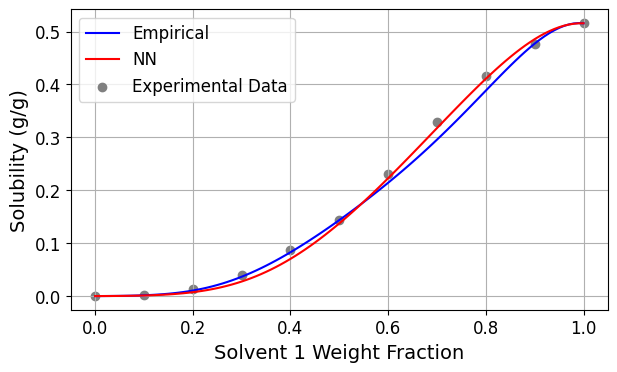

In [191]:
n +=1 
group_index = int(results_df.iloc[n]['group_index'])
group = ja_groups[group_index]



ja_model = JouybanAcreeModel()  
x_values = np.linspace(0, 1, 101)

JA_fit_real = ja_model.predict(
    x_values, 
    results_df['solvent_1_pure'].iloc[n],
    results_df['solvent_2_pure'].iloc[n], 
    results_df['temperature'].iloc[n],
    results_df['J0_JA5'].iloc[n],
    results_df['J1_JA5'].iloc[n],
    results_df['J2_JA5'].iloc[n],
)

JA_fit_NN = ja_model.predict(
    x_values, 
    results_df['solvent_1_pure'].iloc[n],
    results_df['solvent_2_pure'].iloc[n], 
    results_df['temperature'].iloc[n],
    results_df['J0_pred'].iloc[n],
    results_df['J1_pred'].iloc[n],
    results_df['J2_pred'].iloc[n],
)

# Plot the JA model
plt.figure(figsize=(16*1.3/3, 9*1.3/3))
plt.plot(x_values, JA_fit_real, label='Empirical', color='blue')
plt.plot(x_values, JA_fit_NN, label='NN', color='red')


# Add the experimental data points to the plot
plt.scatter(group['solvent_1_weight_fraction'], group['solubility_g_g'], color='gray', label='Experimental Data')
plt.xlabel('Solvent 1 Weight Fraction')
plt.ylabel('Solubility (g/g)')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
from vae_model import VAEWithFeatureSelection

# Create and setup the system with VAE model
system = SystemDesign(
    system_columns=['solvent_1', 'solvent_2'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0', 'J1', 'J2']
)

# Train the VAE model
system.train_model(
    model_class=VAEWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
    epochs=1000,
    batch_size=32,
    verbose=1,
    optimize_hyperparams=True,
    n_calls=100,
    latent_dim=16,
    kl_weight=0.001
)

system.save("../../output/models/vae_model_ss_r.pkl")

Selecting top 10 features using random_forest method...
Selected 57 features (47 from prefixes, 10 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.6279
Function value obtained: 0.0733
Current minimum: 0.0733
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.1192
Function value obtained: 0.0172
Current minimum: 0.0172
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.1670
Function value obtained: 0.0264
Current minimum: 0.0172
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.4395
Function value obtained: 0.0194
Current minimum: 0.0172
Iteration No: 5 started. Evaluating function at random point

ValueError: Input y contains NaN.

In [192]:
from vae_model import VAEWithFeatureSelection

# Create and setup the system with VAE model
system = SystemDesign(
    system_columns=['solvent_1'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0', 'J1', 'J2']
)

# Train the VAE model
system.train_model(
    model_class=VAEWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=50,
    keep_prefixes=['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
    epochs=10,
    batch_size=32,
    verbose=1,
    optimize_hyperparams=True,
    n_calls=100,
    latent_dim=16,
    kl_weight=0.001
)

system.save("../../output/models/vae_model_s_r.pkl")

Selecting top 50 features using random_forest method...
Selected 72 features (22 from prefixes, 50 from selection)
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.5382
Function value obtained: 1.4456
Current minimum: 1.4456
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.1593
Function value obtained: 1.4339
Current minimum: 1.4339
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.8420
Function value obtained: 1.4515
Current minimum: 1.4339
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.2581
Function value obtained: 1.4412
Current minimum: 1.4339
Iteration No: 5 started. Evaluating function at random point.
I

In [ ]:
system = system.load("../../output/models/vae_model.pkl")

In [ ]:
from neural_network_model import NeuralNetworkWithFeatureSelection

# Create and setup the system
system = SystemDesign(
    system_columns=['solvent_1','solvent_2','temperature'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0','J1','J2']
)

# Train the model
system.train_model(
    model_class=NeuralNetworkWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure','solvent_2_pure','system','solubility_','temperature'],
    epochs=1000, 
    batch_size=32, 
    verbose=1,
    optimize_hyperparams=True,
    n_calls=200
)

# Evaluate the model
system.evaluate_model()

# Get predictions and metrics
predictions, actuals, mae = system.get_predictions_and_metrics()

system.save("../../output/models/nn_model_sst_r.pkl")

In [ ]:
from neural_network_model import NeuralNetworkWithFeatureSelection

# Create and setup the system
system = SystemDesign(
    system_columns=['solvent_1','solvent_2'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0','J1','J2']
)

# Train the model
system.train_model(
    model_class=NeuralNetworkWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure','solvent_2_pure','system','solubility_','temperature'],
    epochs=1000, 
    batch_size=32, 
    verbose=1,
    optimize_hyperparams=True,
    n_calls=200
)

# Evaluate the model
system.evaluate_model()

# Get predictions and metrics
predictions, actuals, mae = system.get_predictions_and_metrics()

system.save("../../output/models/nn_model_ss_r.pkl")

In [ ]:
from neural_network_model import NeuralNetworkWithFeatureSelection

# Create and setup the system
system = SystemDesign(
    system_columns=['solvent_1'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0','J1','J2']
)

# Train the model
system.train_model(
    model_class=NeuralNetworkWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure','solvent_2_pure','system','solubility_','temperature'],
    epochs=1000, 
    batch_size=32, 
    verbose=1,
    optimize_hyperparams=True,
    n_calls=200
)

# Evaluate the model
system.evaluate_model()

# Get predictions and metrics
predictions, actuals, mae = system.get_predictions_and_metrics()

system.save("../../output/models/nn_model_s_r.pkl")

In [ ]:
system.save("../../output/models/nn_model.pkl")

In [ ]:
system.load("../../output/models/nn_model.pkl")

In [12]:
from mainv3 import SystemDesign

In [13]:
from xgb_model import XGBoostWithFeatureSelection

# Create and setup the system with XGBoost model
system = SystemDesign(
    system_columns=['solvent_1', 'solvent_2', 'temperature'],
    raw_data_path='curve_fit_results_x_is_7.csv',
    extra_fitted_points=1,
    target_columns=['J0', 'J1', 'J2']
)

# Train the XGBoost model
system.train_model(
    model_class=XGBoostWithFeatureSelection,
    feature_selection_method='random_forest',
    n_features=10,
    keep_prefixes=['solvent_1_pure', 'solvent_2_pure', 'system', 'solubility_', 'temperature'],
    verbose=1,
    optimize_hyperparams=True,
    n_calls=150,
    n_estimators=100,
    max_depth=6
)

# Evaluate the model
system.evaluate_model()

# Get predictions and metrics
predictions, actuals, mae = system.get_predictions_and_metrics()

# Plot feature importance
system.model.plot_feature_importance(top_n=15)

system.save("../../output/models/XGB_model_sst_r.pkl")



Selecting top 10 features using random_forest method...
Selected 389 features (379 from prefixes, 10 from selection)
Optimizing hyperparameters...
Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3967
Function value obtained: 0.2296
Current minimum: 0.2296
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6663
Function value obtained: 0.0856
Current minimum: 0.0856
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4427
Function value obtained: 0.2567
Current minimum: 0.0856
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6483
Function value obtained: 0.3575
Current minimum: 0.0856
Iteration No: 5 started. Evaluat

KeyboardInterrupt: 

In [ ]:
system.save("../../output/models/XGB_model.pkl")

In [ ]:
system.load("../../output/models/XGB_model.pkl")